<a href="https://colab.research.google.com/github/yanada1307/14IF_Multi-label-Emotion-Classification/blob/main/Proyek_PBA_Sprinkle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PROYEK PBA KELOMPOK SPRINKLE**
**Pemrosesan Bahasa Alami**

**Selasa, 16 November 2021**


1.   11S18015 - Yanada Sari Br Situmorang
2.   11S18002 - Putri Era Waty Bakara
3.   11S18010 - N. Priskila Napitupulu
4.   11S18012 - Suryani Vebhitry Siahaan
5.   11S18038 - Grace Winda N Naibaho
6.   11S18063 - Elyta Junetta Siregar





---

In [1]:
!pip3 install datasets transformers -q

In [2]:
!pip install tez

In [3]:
from datasets import load_dataset

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader

import os
import random
import tez
import torch
import torch.nn as nn
import transformers
from sklearn import metrics, model_selection, preprocessing
from transformers import AdamW, get_linear_schedule_with_warmup

In [4]:
go_emotions = load_dataset("go_emotions")

data = go_emotions.data

No config specified, defaulting to: go_emotions/simplified
Reusing dataset go_emotions (/root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
train = go_emotions.data["train"].to_pandas()
valid = go_emotions.data["validation"].to_pandas()
test = go_emotions.data["test"].to_pandas()

In [6]:
print(train.shape, valid.shape, test.shape)

(43410, 3) (5426, 3) (5427, 3)


In [7]:
train.head() 

,text,labels,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj


In [8]:
mapping = {
    0:"admiration",
    1:"amusement",
    2:"anger",
    3:"annoyance",
    4:"approval",
    5:"caring",
    6:"confusion",
    7:"curiosity",
    8:"desire",
    9:"disappointment",
    10:"disapproval",
    11:"disgust",
    12:"embarrassment",
    13:"excitement",
    14:"fear",
    15:"gratitude",
    16:"grief",
    17:"joy",
    18:"love",
    19:"nervousness",
    20:"optimism",
    21:"pride",
    22:"realization",
    23:"relief",
    24:"remorse",
    25:"sadness",
    26:"surprise",
    27:"neutral",
}

n_labels = len(mapping)

In [9]:
def one_hot_labels(df):
    dict_labels= []
    for i in tqdm(range(len(df))):
        d = [0]*n_labels
        labels = df.iloc[i]["labels"]
        
        for label in labels:
            d[label] = 1
        dict_labels.append(d)
        
    return pd.DataFrame(dict_labels)

In [10]:
train_oh_labels = one_hot_labels(train)
valid_oh_labels = one_hot_labels(valid)
test_oh_labels = one_hot_labels(test)

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

In [11]:
train_oh_labels.shape

(43410, 28)

In [12]:
train = pd.concat([train, train_oh_labels], axis=1)
valid = pd.concat([valid, valid_oh_labels], axis=1)
test = pd.concat([test, test_oh_labels], axis=1)

In [13]:
train.head()

,text,labels,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,My favourite food is anything I didn't have to...,[27],eebbqej,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,[14],ed7ypvh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Dirty Southern Wankers,[3],ed0bdzj,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


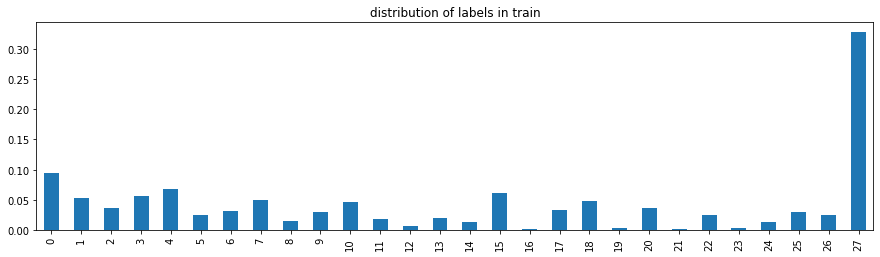

In [14]:
fig = plt.figure(figsize=(15, 13))

ax1 = plt.subplot(3, 1, 1)
train[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax1, title="distribution of labels in train")

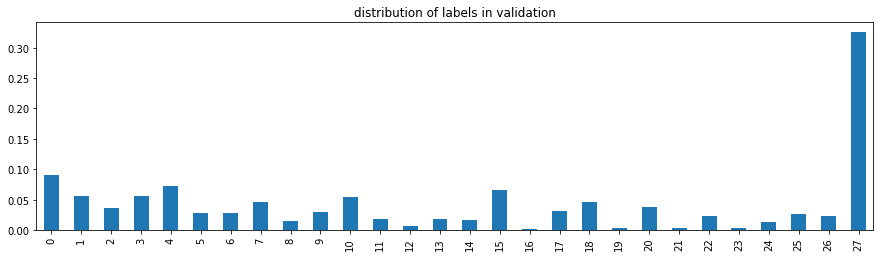

In [15]:
fig = plt.figure(figsize=(15, 13))

ax2 = plt.subplot(3, 1, 2)
valid[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax2, title="distribution of labels in validation")

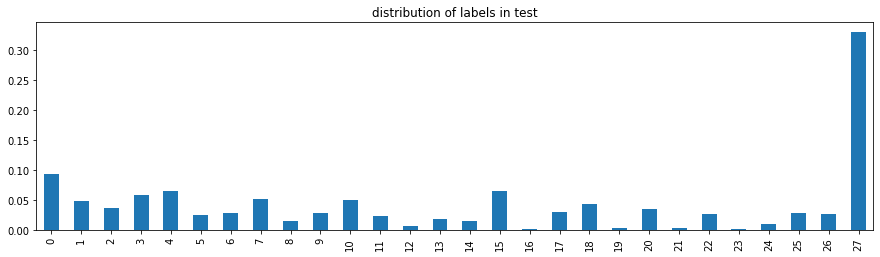

In [16]:
fig = plt.figure(figsize=(15, 13))

ax3 = plt.subplot(3, 1, 3)
test[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax3, title="distribution of labels in test")

In [17]:
def inspect_data(label, n=5):
    samples = train[train[label] == 1].sample(5)
    sentiment = mapping[label]
    
    print(f"examples from {sentiment}")
    print()
    for text in samples["text"]:
        print(text)
        print("---")

In [18]:
inspect_data(0)

examples from admiration

You’re the best grandmother a person could hope to have.
---
I absolutely love that idea. I went on an anniversary trip with a couple once and it was amazing! We had so much fun.
---
Fun movie, good choices of songs, and excellent visuals
---
Maaaan, that woman is crazy! And the straightjacket type!
---
Cool! Tell me more about yourself---PM me if you're more comfortable.
---


In [19]:
inspect_data(1)

examples from amusement

😅 I wrote that to indicate tears of relief and happiness but what I was actually doing was laughing like a lunatic knowing that I wasn’t alone.
---
He had to say, "But alas" which makes this soo funny.
---
It doesn't, it just resets back to 1 *before* adding in your upvote. You're not gaming the system lol
---
I'm very much like that, here's my face lol You're either interested or you're not
---
Is that her official name now? [NAME]
---


In [20]:
class GoEmotionDataset():
    def __init__(self, texts, targets):
        self.texts = texts
        self.targets = targets
        self.tokenizer = transformers.SqueezeBertTokenizer.from_pretrained(
            "squeezebert/squeezebert-uncased", do_lower_case=True
        )
        self.max_len = 35
 
    def __len__(self):
        return len(self.texts)

    
    def __getitem__(self, index):
        target = self.targets[index]
        text = self.texts[index]

        inputs = self.tokenizer.encode_plus(text,
                                            None,
                                            add_special_tokens=True,
                                            max_length=self.max_len,
                                            padding="max_length",
                                            truncation=True)
        
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "targets": torch.tensor(self.targets[index], dtype=torch.long),
        }